# Load dataset

In [1]:
%%capture
!pip install mediapipe==0.9.0.1
!pip install protobuf==3.20.*
!pip install scikit-image

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe as mp
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc

In [3]:
random.seed(42)

In [4]:
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

TensorFlow v2.10.1
Mediapipe v0.9.0.1


In [5]:
dataset_df = pd.read_csv('kaggle_dataset/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (67208, 5)


In [6]:
dataset_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


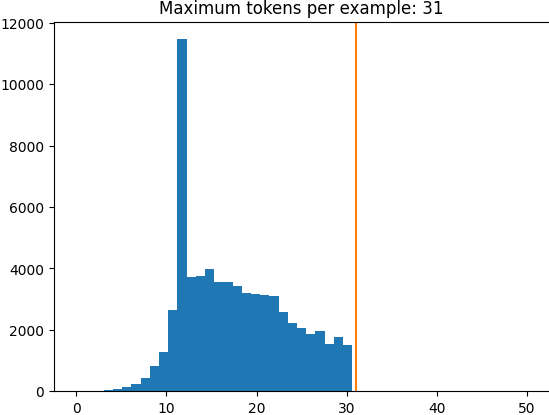

In [70]:
lengths = []
def gather_lenghts(phrase: str):
    lengths.append(len(phrase))
    return phrase
dataset_df.phrase.apply(gather_lenghts)

plt.hist(lengths, np.linspace(0, 50, 50))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}')

In [7]:
def random_sequence():
    # Fetch sequence_id, file_id, phrase from first row
    sequence_id, file_id, phrase, path = dataset_df.sample(n=1).iloc[0][['sequence_id', 'file_id', 'phrase', 'path']]
    print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")
    
    # Fetch data from parquet file
    sample_sequence_df = pq.read_table(f"kaggle_dataset/{path}",
        filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
    print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))
    
    return sample_sequence_df

In [8]:
random_sequence()

sequence_id: 728493128, file_id: 1997878546, phrase: 765 winick street southeast
Full sequence dataset shape is (232, 1630)


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
728493128,0,0.587972,0.589083,0.590677,0.577834,0.588589,0.588635,0.588919,0.500245,0.587914,...,-0.087011,-0.085880,-0.051083,-0.069975,-0.067817,-0.063566,-0.043781,-0.057574,-0.055836,-0.051170
728493128,1,0.585744,0.591577,0.592832,0.579532,0.590976,0.590691,0.590098,0.496784,0.588643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728493128,2,0.585172,0.587674,0.589794,0.576673,0.587130,0.587331,0.588157,0.496852,0.587144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728493128,3,0.585425,0.588878,0.590616,0.577745,0.588355,0.588440,0.589023,0.497621,0.588090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728493128,4,0.584289,0.588023,0.589810,0.577185,0.587624,0.587886,0.588810,0.497057,0.588141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728493128,227,0.584495,0.587433,0.588185,0.575722,0.587158,0.587136,0.587077,0.490044,0.586400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728493128,228,0.582954,0.585616,0.586574,0.574303,0.585354,0.585519,0.586048,0.492582,0.585704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728493128,229,0.583633,0.588242,0.588695,0.576821,0.588121,0.588228,0.588395,0.493416,0.587963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# import json

# name_to_idx = {}
# for i, name in enumerate(sample_sequence_df.columns):
#     name_to_idx[name] = i
    
# json.dumps()

## Animation preview

In [10]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def collect_landmarks_oftype(_type: str, frame_data: pd.Series):
    x_type = frame_data.filter(regex=f"x_{_type}.*").values
    y_type = frame_data.filter(regex=f"y_{_type}.*").values
    z_type = frame_data.filter(regex=f"z_{_type}.*").values
    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(x_type, y_type, z_type):
        landmarks.landmark.add(x=x, y=y, z=z)
    return landmarks
        
def produce_video_from_seq(seq_df: pd.DataFrame):
    frames = []
    for seq_idx in range(len(seq_df)):
        frame = np.zeros((600, 600, 3))
        frame_data = seq_df.iloc[seq_idx]
        
        # Right hand
        right_hand_landmarks = collect_landmarks_oftype("right_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Left Hand
        left_hand_landmarks = collect_landmarks_oftype("left_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Face
        face_landmarks = collect_landmarks_oftype("face", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        
        # Pose
        pose_landmarks = collect_landmarks_oftype("pose", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        
        frames.append(frame.astype(np.uint8))
    return frames

In [12]:
video = produce_video_from_seq(random_sequence())
create_animation(video)

sequence_id: 1488327710, file_id: 1647220008, phrase: 1942 kaylii
Full sequence dataset shape is (99, 1630)


# Save to TFRecords

In [13]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

In [14]:
def save_tfrecords_to(folder: str):
    # Loop through each file_id
    for file_path in tqdm(dataset_df.path.unique()):
        # Parquet file name
        pq_file = f"kaggle_dataset/{file_path}"
        
        parts = file_path.split('/')
        last_part = parts[-1]
        number_string = last_part.split('.')[0]
        file_id = int(number_string)
        
        # Filter train.csv and fetch entries only for the relevant file_id
        file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
        # Fetch the parquet file
        parquet_df = pq.read_table(pq_file,columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()

        # File name for the updated data
        tf_file = f"{folder}/{file_id}.tfrecord"
        parquet_numpy = parquet_df.to_numpy()
        # Initialize the pointer to write the output of each `for loop` below as a sequence into the file.
        with tf.io.TFRecordWriter(tf_file) as file_writer:
            # Loop through each sequence in file.
            for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
                # Fetch sequence data
                frames = parquet_numpy[parquet_df.index == seq_id]

                # Calculate the number of rows that only have NaN values -> on how many frames each hand is fully visible
                r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
                l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
                # Number of frames where the dominant hand is visible (dominant = visible on more frames than the other hand)
                num_of_visible = max(r_nonan, l_nonan)

                # TODO experiment with this
                if 2*len(phrase) < num_of_visible:
                    features = {FEATURE_COLUMNS[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                    features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                    record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                    file_writer.write(record_bytes)

In [15]:
folder_name = "preprocessed"
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
    save_tfrecords_to(folder_name)
else:
    print(f"Warning: Tfrecords already exist! Delete the {folder_name} folder to regenerate them!")

# Fetch from TFRecords

In [16]:
tf_records = dataset_df.file_id.map(lambda x: f'{folder_name}/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [18]:
with open ("kaggle_dataset/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [46]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [125]:
FRAME_LEN = 128
MAX_PHRASE_LEN = 30

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    
    max_len_plus = MAX_PHRASE_LEN + 1
    amount_to_pad = max_len_plus - tf.shape(phrase)[0]
    
    if amount_to_pad > 0:
        phrase = tf.pad(phrase, paddings=[[0, amount_to_pad]], mode = 'CONSTANT', constant_values = pad_token_idx)
    else:
        phrase = phrase[:max_len_plus]
    
    return (pre_process(landmarks), phrase[:-1]), phrase[1:]

In [126]:
batch_size = 32
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len])
.map(decode_fn)
.map(convert_fn)
.batch(batch_size)
.shuffle(buffer_size=tf.data.AUTOTUNE)
.prefetch(buffer_size=tf.data.AUTOTUNE)
.cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [127]:
# input_shape = None
# phrase_shape = None

# Create an iterator for the train and valid datasets
train_iterator = iter(train_ds)
valid_iterator = iter(valid_ds)

# Print data points from the training dataset
print("Training Data:")
(landmarks, context), phrase = next(train_iterator)
input_shape = (landmarks.shape[1], landmarks.shape[2])
print("Encoder input (Landmarks:)")
print(type(landmarks))
print(landmarks.shape)
print(landmarks[0])
print("-" * 40)
print("Decoder input (Context):")
print(context.shape)
print(context[0])
print("-" * 40)
print("Model target output (Phrase):")
print(phrase.shape)
print(phrase[0])

Training Data:
Encoder input (Landmarks:)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 128, 78)
tf.Tensor(
[[-0.3400935   1.9302673   2.2366345  ...  0.29593182  0.8061352
  -4.0462556 ]
 [-0.25333148  2.0530148   2.5154905  ...  0.31412765  0.7994566
  -4.0204024 ]
 [-0.3305323   1.9902551   2.1952682  ...  0.25186273  0.81696874
  -3.6967642 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(128, 78), dtype=float32)
----------------------------------------
Decoder input (Context):
(32, 30)
tf.Tensor(
[60 21 22 18 23  0 34 46  0 20 21 22 15 61 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59], shape=(30,), dtype=int32)
----------------------------------------
Model target output (Phrase):
(32, 30)
tf.Tensor(
[21 22 18 23  0 34 46  0 20 21 22 15 61 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 

# Creating the Model

In [122]:
# https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb#scrollTo=1Rz82wEs5biZ

def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

MAX_LEN = 2048

class PositionalTokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)  # , mask_zero=True
        self.pos_encoding = positional_encoding(length=MAX_LEN, depth=d_model)

#     def compute_mask(self, *args, **kwargs):
#         return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

NUM_CONV_LAYERS = 3
FILTER_SIZE = 11
    
class PositionalLandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model):
        super().__init__()
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        # maybe add input for Convs
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, FILTER_SIZE, padding="same", activation="relu")
            for _ in range(NUM_CONV_LAYERS)
        ])
        self.pos_encoding = positional_encoding(length=MAX_LEN, depth=d_model)
        
    def call(self, x):
        #length = tf.shape(x)[1]
        x = self.conv_block(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # print(self.pos_encoding[tf.newaxis, :self.len_of_seq, :].shape) # (1, 128, 512) this isnt semantically correct
        x = x + self.pos_encoding[tf.newaxis, :self.len_of_seq, :]
        return x
    
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)
       
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
    
        x = self.add([x, attn_output])
        x = self.layernorm(x)
    
        return x
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
    
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, len_of_seq, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
        super().__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = PositionalLandmarkEmbedding(
            len_of_seq, d_model)
    
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is landmark sequences with shape: (batch, seq_len, features)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
        
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
    
        return x  # Shape `(batch_size, seq_len, d_model)`.
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
    
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
        
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
    
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores
    
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = PositionalTokenEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]
    
        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
    
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    
        # The shape of x is (batch_size, target_seq_len, d_model).
        return x
    
class Transformer(tf.keras.Model):
    def __init__(self, *, len_lm_seq, num_enc_layers, num_dec_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(len_of_seq=len_lm_seq,
                               num_layers=num_enc_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               dropout_rate=dropout_rate)
        
        self.decoder = Decoder(num_layers=num_dec_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)
    
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        landmark_seq, prev_gen_context  = inputs
    
        encoded_lm_seq = self.encoder(landmark_seq)  # (batch_size, landmark_seq_len, d_model)
        x = self.decoder(prev_gen_context, encoded_lm_seq)  # (batch_size, target_len, d_model)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

In [123]:
d_model = 512

transformer = Transformer(
    len_lm_seq=FRAME_LEN,
    num_enc_layers=2,
    num_dec_layers=1,
    d_model=d_model,
    num_heads=4,
    dff=512,
    input_vocab_size=len(char_to_num),
    target_vocab_size=len(char_to_num),
    dropout_rate=0.1)

In [124]:
%%time
(lm, ctx), _label = next(iter(train_ds))
output = transformer(inp)

print(lm.shape)
print(ctx.shape)
print(output.shape)

(32, 128, 78)
(32, 28)
(32, 28, 62)


In [128]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [129]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

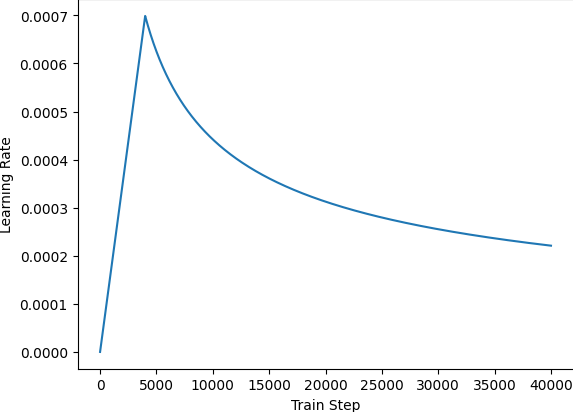

In [130]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [131]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [132]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [240]:
%%time
transformer.fit(train_ds,
                epochs=10,
                validation_data=valid_ds)

Epoch 1/10
1263/1263 [==============================] - 4187s 3s/step - loss: 0.9969 - masked_accuracy: 0.7130 - val_loss: 0.9791 - val_masked_accuracy: 0.7172
Epoch 2/10
1263/1263 [==============================] - 4188s 3s/step - loss: 1.0333 - masked_accuracy: 0.6996 - val_loss: 1.0007 - val_masked_accuracy: 0.7087
Epoch 3/10
1263/1263 [==============================] - 4192s 3s/step - loss: 0.9355 - masked_accuracy: 0.7266 - val_loss: 0.9736 - val_masked_accuracy: 0.7159
Epoch 4/10
1263/1263 [==============================] - 4208s 3s/step - loss: 0.8705 - masked_accuracy: 0.7451 - val_loss: 0.8871 - val_masked_accuracy: 0.7393
Epoch 5/10
1263/1263 [==============================] - 4246s 3s/step - loss: 0.8683 - masked_accuracy: 0.7443 - val_loss: 0.9619 - val_masked_accuracy: 0.7179
Epoch 6/10
1263/1263 [==============================] - 4265s 3s/step - loss: 1.0126 - masked_accuracy: 0.6983 - val_loss: 0.8834 - val_masked_accuracy: 0.7413
Epoch 7/10
1263/1263 [==================

KeyboardInterrupt: 

In [ ]:
???

In [241]:
# Manual inference on test input
test_inp = np.zeros((1, 128, 78))
test_ctx = np.array([[start_token_idx]])
logits = transformer((test_inp, test_ctx))
pred_idx = np.argmax(tf.nn.softmax(logits)[0][0])
num_to_char[pred_idx]

'+'

# Save model

In [245]:
tf_chars = tf.constant(list(char_to_num.keys()), dtype=tf.string)
tf_nums = tf.constant(list(char_to_num.values()), dtype=tf.int64)

class FingerSpellingTransformer(tf.Module):
    def __init__(self, model: Transformer):
        super(FingerSpellingTransformer, self).__init__()
        self.model = model
        
        self.tf_char_to_num = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_chars,
                values=tf_nums,
            ),
            default_value=tf.constant(-1, dtype=tf.int64),
            name="tf_char_to_num_lut"
        )
        
        self.tf_num_to_char = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_nums,
                values=tf_chars,
            ),
            default_value=tf.constant("unknown", dtype=tf.string),
            name="tf_num_to_char_lut"
        )
        

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[tf.constant(input_shape[0]), tf.constant(input_shape[1])], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.string), # TODO String should be limited in length!!! fix that
    ])
    def predict(self, landmarks, ctx):
        # Prepare input
        ctx_chars = tf.strings.unicode_split(ctx, input_encoding='UTF-8')
        ctx_tokens = self.tf_char_to_num.lookup(ctx_chars)
        batched_ctx_tokens = tf.expand_dims(ctx_tokens, axis=0) # Adds first ("batch") dimension to the tensor
        batched_landmarks = tf.expand_dims(landmarks, axis=0)
        
        # Inference
        logits = self.model((batched_landmarks, batched_ctx_tokens))
        
        # Parse result
        probabilities = tf.nn.softmax(logits)[0][0]
        pred_prob = tf.reduce_max(probabilities)
        pred_idx = tf.argmax(probabilities)
        pred_char = self.tf_num_to_char.lookup(pred_idx)
        
        return {'result' : pred_char, 'confidence': pred_prob}

In [246]:
transformer_wrapper = FingerSpellingTransformer(transformer)

In [247]:
%%time
transformer_wrapper.predict(np.zeros((128, 78)), "abc")

CPU times: total: 1.05 s
Wall time: 487 ms


{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.22721346>}

In [206]:
tf.saved_model.save(transformer_wrapper, export_dir='test_model_saving')

INFO:tensorflow:Assets written to: test_model_saving\assets


INFO:tensorflow:Assets written to: test_model_saving\assets


In [207]:
reloaded = tf.saved_model.load('test_model_saving')

In [209]:
reloaded.predict(np.zeros((128, 78)), "abc")

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'n'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.22607808>}

# TFlite struggle

## Method 1

In [210]:
# Convert to TFlite model
converter = tf.lite.TFLiteConverter.from_saved_model('test_model_saving')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

ConverterError: <unknown>:0: error: loc(callsite(callsite(fused["UnicodeDecode:", "UnicodeSplit/UnicodeDecode@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.UnicodeDecode' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["UnicodeDecode:", "UnicodeSplit/UnicodeDecode@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Range:", "UnicodeSplit/UnicodeEncode/RaggedFromTensor/RaggedFromUniformRowLength/RowPartitionFromUniformRowLength/range@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Range:", "UnicodeSplit/UnicodeEncode/RaggedFromTensor/RaggedFromUniformRowLength/RowPartitionFromUniformRowLength/range@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["UnicodeEncode:", "UnicodeSplit/UnicodeEncode/UnicodeEncode/UnicodeEncode@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.UnicodeEncode' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["UnicodeEncode:", "UnicodeSplit/UnicodeEncode/UnicodeEncode/UnicodeEncode@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["MatrixBandPart:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/MatrixBandPart@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.MatrixBandPart' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["MatrixBandPart:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/MatrixBandPart@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/key/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/key/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/query/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/query/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/value/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/causal_self_attention_6/multi_head_attention_26/value/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/cross_attention_6/multi_head_attention_27/query/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Einsum:", "transformer_6/decoder_6/decoder_layer_6/cross_attention_6/multi_head_attention_27/query/einsum/Einsum@__inference_predict_123934"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_124090"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: Einsum, MatrixBandPart, Range, UnicodeDecode, UnicodeEncode
Details:
	tf.Einsum(tensor<*xf32>, tensor<512x4x512xf32>) -> (tensor<?x?x4x512xf32>) : {device = "", equation = "abc,cde->abde"}
	tf.MatrixBandPart(tensor<1x?x?xi1>, tensor<i32>, tensor<i32>) -> (tensor<1x?x?xi1>) : {device = ""}
	tf.Range(tensor<i64>, tensor<i64>, tensor<i64>) -> (tensor<?xi64>) : {device = ""}
	tf.UnicodeDecode(tensor<1x!tf_type.string>) -> (tensor<2xi64>, tensor<?xi32>) : {Tsplits = i64, device = "", errors = "replace", input_encoding = "UTF-8", replace_control_characters = false, replacement_char = 65533 : i64}
	tf.UnicodeEncode(tensor<?xi32>, tensor<?xi64>) -> (tensor<?x!tf_type.string>) : {Tsplits = i64, device = "", errors = "replace", output_encoding = "UTF-8", replacement_char = 65533 : i64}



## Method 2

In [212]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(transformer_wrapper)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\mdancso\AppData\Local\Temp\tmpr5wcdhhf\assets


INFO:tensorflow:Assets written to: C:\Users\mdancso\AppData\Local\Temp\tmpr5wcdhhf\assets


ConverterError: C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: error: 'tf.UnicodeDecode' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: note: Error code: ERROR_NEEDS_FLEX_OPS
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: error: 'tf.Range' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: note: Error code: ERROR_NEEDS_FLEX_OPS
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: error: 'tf.UnicodeEncode' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1176:0: note: Error code: ERROR_NEEDS_FLEX_OPS
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: error: 'tf.MatrixBandPart' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: note: Error code: ERROR_NEEDS_FLEX_OPS
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: error: 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: note: Error code: ERROR_NEEDS_FLEX_OPS
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: error: 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: note: Error code: ERROR_NEEDS_FLEX_OPS
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: error: 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: note: Error code: ERROR_NEEDS_FLEX_OPS
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: error: 'tf.Einsum' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
C:\Users\mdancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1097:0: note: Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: Einsum, MatrixBandPart, Range, UnicodeDecode, UnicodeEncode
Details:
	tf.Einsum(tensor<*xf32>, tensor<512x4x512xf32>) -> (tensor<?x?x4x512xf32>) : {device = "", equation = "abc,cde->abde"}
	tf.MatrixBandPart(tensor<1x?x?xi1>, tensor<i32>, tensor<i32>) -> (tensor<1x?x?xi1>) : {device = ""}
	tf.Range(tensor<i64>, tensor<i64>, tensor<i64>) -> (tensor<?xi64>) : {device = ""}
	tf.UnicodeDecode(tensor<1x!tf_type.string>) -> (tensor<2xi64>, tensor<?xi32>) : {Tsplits = i64, device = "", errors = "replace", input_encoding = "UTF-8", replace_control_characters = false, replacement_char = 65533 : i64}
	tf.UnicodeEncode(tensor<?xi32>, tensor<?xi64>) -> (tensor<?x!tf_type.string>) : {Tsplits = i64, device = "", errors = "replace", output_encoding = "UTF-8", replacement_char = 65533 : i64}



# Testing

## On Test dataset

In [56]:
batches = [batch for batch in valid_ds]

preds_list = []
ground_truth_list = []

for batch in batches[:1]:
    source = batch[0]
    target = batch[1].numpy()
    bs = tf.shape(source)[0]
    preds = model.generate(source, start_token_idx)
    preds = preds.numpy()

    for i in range(bs):
        target_text = "".join([idx_to_char[_] for _ in target[i, :]])
        ground_truth_list.append(target_text.replace('P', ''))
        prediction = ""
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == end_token_idx:
                break
        preds_list.append(prediction)

for i in range(30):
    print(ground_truth_list[i])
    print(preds_list[i])
    print('\n~~~\n')

AttributeError: 'Transformer' object has no attribute 'generate'

## Real life testing

In [217]:
import cv2
from IPython.display import display, Image

In [218]:
# # Pose coordinates for hand movement.
# LPOSE = [13, 15, 17, 19, 21]
# RPOSE = [14, 16, 18, 20, 22]
# POSE = LPOSE + RPOSE

# X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
# Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
# Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

# FEATURE_COLUMNS = X + Y + Z

from itertools import chain

# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

def extract_from_result(res):
    # Extract specific pose landmarks if available
    px = []
    py = []
    pz = []
    if res.pose_landmarks:
        for i in POSE:
            lm = res.pose_landmarks.landmark[i]
            px.append(lm.x)
            py.append(lm.y)
            pz.append(lm.z)
    else:
        px = [0.0]*len(POSE)
        py = [0.0]*len(POSE)
        pz = [0.0]*len(POSE)

    # Extract left hand landmarks if available
    lx = []
    ly = []
    lz = []
    if res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            lx.append(lm.x)
            ly.append(lm.y)
            lz.append(lm.z)
    else:
        lx = [0.0]*21
        ly = [0.0]*21
        lz = [0.0]*21

    # Extract right hand landmarks if available
    rx = []
    ry = []
    rz = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            rx.append(lm.x)
            ry.append(lm.y)
            rz.append(lm.z)
    else:
        rx = [0.0]*21
        ry = [0.0]*21
        rz = [0.0]*21

    return list(chain(rx, lx, px, ry, ly, py, rz, lz, pz))

In [219]:
is_signing_model = keras.models.load_model("detect_signing.hdf5")
is_signing_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1)                 632       
                                                                 
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
Total params: 636
Trainable params: 636
Non-trainable params: 0
_________________________________________________________________


In [252]:
# Többségi döntéses kiértékelés
# signing detection
# az egész previous context átadásával
# with 

# camera - 0
# video - "path/to/file"
file_or_camera = "test_videos/whale.mp4"

from collections import Counter
from collections import deque

inner_fifo = deque(maxlen=10)
confidence_number = 6
INP_LEN = 15
signing_detection_model_input = list(np.zeros((INP_LEN, 156)))
model_data = []
last_output = start_token_idx
context = "<"

def process_model_output(new_output: int, prob: float):
    global last_output
    global context
    
#     if prob < 0.2:
#         return
    
    inner_fifo.append(new_output)
    
    pred_char, count = Counter(inner_fifo).most_common(1)[0]
    if count >= confidence_number:
        if last_output != pred_char:
            last_output = pred_char
            
            # Predicted the end
            if pred_char == '>':
                # restart the detection
                last_output = '<'
                inner_fifo.clear()
                print("\\n")
            else:
                context += pred_char
                print(pred_char, end="")


video = cv2.VideoCapture(file_or_camera)
display_handle=display(None, display_id=True)
try:
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while True:
            _, frame = video.read()

            if frame is None:
                break

            # Resize the frame to the target width and height
            image = cv2.resize(frame, (360, 240))

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = holistic.process(image)
            data = extract_from_result(results)
            
            signing_detection_model_input.pop(0)
            signing_detection_model_input.append(data)
            
            is_signing = np.argmax(is_signing_model.predict(np.array([signing_detection_model_input]), verbose=0)) == 1
            if is_signing:
                print("*", end="")
                if len(model_data) >= INP_LEN:
                    model_data.pop(0)
                model_data.append(data)
                inp = pre_process(model_data)
                res = transformer_wrapper.predict(inp, context)
                char = res['result'].numpy().decode("utf8")
                prob = res['confidence'].numpy()
                process_model_output(char, prob)
            else:
                print("-", end="")

#             if len(model_data) >= INP_LEN:
#                 model_data.pop(0)
#             model_data.append(data)
#             inp = pre_process(model_data)
#             preds = model.generate_precisely(np.array([inp]), last_output, 1)
#             process_model_output(preds[0, 1].numpy())
            

            # Draw landmark annotation on the image.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(
                image,
                results.face_landmarks,
                mp_holistic.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())

            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles
                .get_default_pose_landmarks_style())

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
            )

            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
            )

            _, frame = cv2.imencode('.jpeg', image)
            display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

-----------------------------------------*************w******************h*******a***********l********e***********----------------

In [46]:
# Többségi döntéses kiértékelés
# signing detection
# csak az előző karaktert átadva contextnek

# camera - 0
# video - "path/to/file"
file_or_camera = "bear.mp4"

from collections import Counter
from collections import deque

inner_fifo = deque(maxlen=10)
confidence_number = 7
INP_LEN = 15
signing_detection_model_input = list(np.zeros((INP_LEN, 156)))
model_data = []
last_output = start_token_idx
whole_pred = ""

def process_model_output(new_output: int):
    global last_output
    global whole_pred
    
    whole_pred += idx_to_char[new_output]
    
    inner_fifo.append(new_output)
    
    predicted_idx, count = Counter(inner_fifo).most_common(1)[0]
    if count >= confidence_number:
        if last_output != predicted_idx:
            last_output = predicted_idx
            
            # Predicted the end
            if predicted_idx == end_token_idx:
                # restart the detection
                last_output = start_token_idx
                inner_fifo.clear()
                print("\\n")
            else:
                print(idx_to_char[predicted_idx], end="")


video = cv2.VideoCapture(file_or_camera)
display_handle=display(None, display_id=True)
try:
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while True:
            _, frame = video.read()

            if frame is None:
                break

            # Resize the frame to the target width and height
            image = cv2.resize(frame, (360, 240))

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = holistic.process(image)
            data = extract_from_result(results)
            
            signing_detection_model_input.pop(0)
            signing_detection_model_input.append(data)
            
#             is_signing = np.argmax(is_signing_model.predict(np.array([signing_detection_model_input]), verbose=0)) == 1
#             if is_signing:
#                 print("*", end="")
#                 if len(model_data) >= INP_LEN:
#                     model_data.pop(0)
#                 model_data.append(data)
#                 inp = pre_process(model_data)
#                 preds = model.generate_precisely(np.array([inp]), last_output, 1)
#                 process_model_output(preds[0, 1].numpy())
#             else:
#                 print("-", end="")

            if len(model_data) >= INP_LEN:
                model_data.pop(0)
            model_data.append(data)
            inp = pre_process(model_data)
            preds = model.generate_precisely(np.array([inp]), last_output, 1)
            process_model_output(preds[0, 1].numpy())
            

            # Draw landmark annotation on the image.
#             image.flags.writeable = True
#             image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#             mp_drawing.draw_landmarks(
#                 image,
#                 results.face_landmarks,
#                 mp_holistic.FACEMESH_CONTOURS,
#                 landmark_drawing_spec=None,
#                 connection_drawing_spec=mp_drawing_styles
#                 .get_default_face_mesh_contours_style())

#             mp_drawing.draw_landmarks(
#                 image,
#                 results.pose_landmarks,
#                 mp_holistic.POSE_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles
#                 .get_default_pose_landmarks_style())

#             mp_drawing.draw_landmarks(
#                 image,
#                 results.left_hand_landmarks,
#                 mp_holistic.HAND_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
#             )

#             mp_drawing.draw_landmarks(
#                 image,
#                 results.right_hand_landmarks,
#                 mp_holistic.HAND_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
#             )

            #frame = cv2.flip(image, 1)
            _, frame = cv2.imencode('.jpeg', image)
            display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

beloun

In [49]:
# várjunk amíg megtelik egy frame aztán pred greedy módon

model_data = []
video = cv2.VideoCapture("whale.mp4")
display_handle=display(None, display_id=True)
try:
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while True:
            _, frame = video.read()
            
            if frame is None:
                break

            # Resize the frame to the target width and height
            image = cv2.resize(frame, (360, 240))

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = holistic.process(image)
            data = extract_from_result(results)
            if len(model_data) == 100:
                print("Frames filled up")
                break
                
            model_data.append(data)
           
            # Draw landmark annotation on the image.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(
                image,
                results.face_landmarks,
                mp_holistic.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())

            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles
                .get_default_pose_landmarks_style())

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
            )

            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
            )

            #frame = cv2.flip(image, 1)
            _, frame = cv2.imencode('.jpeg', image)
            display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)
    

# Run the model
inp = pre_process(model_data)
preds = model.generate(np.array([inp]), start_token_idx)
prediction = ""
for idx in preds[0, 1:]:
    prediction += idx_to_char[idx]
    last_char = idx_to_char[idx]
    if idx == end_token_idx:
        break
        
prediction

None

Frames filled up


'whe whal a lew ho>'